# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
# !pip install anndata lightgbm

In [2]:
# !conda install -c conda-forge graph-tool -y 

In [3]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import tqdm
import scipy
import json
from regression import format_folder

os.environ['KMP_DUPLICATE_LIB_OK']='True'

work_dir = '../output'
resource_dir = '../resources'
os.makedirs(f'{work_dir}', exist_ok=True)

In [4]:
methods = ['Random',
 'CollectRI',
 'FigR',
 'CellOracle',
 'GRaNIE',
 'ANANSE',
 'scGLUE',
 'Scenic+',
 'HKG',
 'Positive',
 'Negative',
 'Positive Control',
 'Negative Control']


# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRaNIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRANIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKGs': 'darkblue',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}
# LINESTYLES = {
#     'Random': '-',
#     'CollectRI': '--',
#     'FigR': '-.',
#     'CellOracle': ':',
#     'GRaNIE': ':',
#     'ANANSE': '--',
#     'scGLUE': '-.',
#     'Scenic+': '-',
# }

surragate_names = {
    'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
    'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
    'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
    'FigR': 'FigR', 'figr':'FigR', 'figr_sign':'FigR-signs',
    'baseline':'Baseline',
    'cov_net': 'Pearson cov',
    'GRANIE': 'GRANIE', 'granie':'GRANIE',
    'ANANSE': 'ANANSE', 'ananse':'ANANSE',
    'scGLUE': 'scGLUE', 'scglue':'scGLUE',
    'HKG': 'HKG', 'HKGs':'HKG',
    'positive-control': 'Positive Control', 'positive_control': 'Positive Control',
    'negative-control': 'Negative Control', 'negative_control':'Negative Control',
    'pearson':'APR',
    'lognorm': 'SLA',
    'SL':'SLA',
    'scgen_pearson':'scGEN-APR', 'scgen_lognorm':'scGEN-SLA', 'seurat_pearson':'Seurat-APR', 'seurat_lognorm':'Seurat-SLA',
}

# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRANIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRANIE': '-',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': ':',
    'Positive Control': '-',
    'Negative Control': '-'
}

MARKERS = {
    'Random': '.',
    'CollectRI': '.',
    'FigR': 'o',
    'CellOracle': 'd',
    'GRANIE': 'v',
    'ANANSE': 's',
    'scGLUE': 'x',
    'Scenic+': '*',
    'Positive Control': '.',
    'Negative Control': '.'
}

In [5]:
# ## Formatize filing 
# def format_folder_old(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample=None):
#     return f'{work_dir}/benchmark/_scores/subsample_{subsample}/exclude_missing_genes_{exclude_missing_genes}/{reg_type}/theta_{theta}_tf_n_{tf_n}/{norm_method}'


# def format_file(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample=None, manipulate=None):
#     folder = f'{work_dir}/benchmark/scores/{grn_model}/{exclude_missing_genes}_{tf_n}_{subsample}_{}
#     return 
    
#     subsample_{subsample}/exclude_missing_genes_{exclude_missing_genes}/{reg_type}/theta_{theta}_tf_n_{tf_n}/{norm_method}'



# for grn_model in grn_models:
#     for exclude_missing_genes in [True, False]:
#         for tf_n in [140, None]:
#             for subsample in [200, None]:
#                 for norm_method in datasets:
#                     for theta in np.linspace(0, 1, 5):
#                         for reg_type in ['ridge','GB']:
#                             file = f'{format_folder_old(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{grn_model}_{manipulate}.json'
#                             if not os.path.exists(file):
#                                 print(f'Missing file: {file}')
#                             else:
#                                 if tf_n is None:
#                                     tf_n = -1
#                                 if subsample is None:
#                                     subsample = -1
#                                 if exclude_missing_genes:
#                                     exclude_missing_genes = 
#                                 else:
#                                     exclude_missing_genes = -1
#                                 # with open(file, 'r') as f:
#                                 #     data = json.load(f)
#                                 pass 


# # file = f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{grn_model}_{manipulate}.json'


In [6]:
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


In [7]:
grn_model_names = ['figr', 'celloracle', 'granie', 'scglue', 'scenicplus']

n_nets = len(grn_model_names)


grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [8]:
tfs_n_list = [grn.source.unique().shape[0] for grn in grn_models_dict.values()]
print(np.min(tfs_n_list), np.median(tfs_n_list), np.max(tfs_n_list))

140 389.0 557


In [9]:
aa

NameError: name 'aa' is not defined

# main analysis

In [10]:
datasets = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm'] # ['seurat_lognorm', 'scgen_pearson']
grn_models = ['negative_control', 'collectRI', 'granie', 'celloracle', 'figr', 'scglue', 'scenicplus', 'positive_control']


def extract_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets, grn_models):
    mat = []
    for i_plot, norm_method in enumerate(datasets):
        row = []
        for grn_model in grn_models:
            file = f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{grn_model}_{manipulate}.json'
            if not os.path.exists(file):
                print(f'Missing file: {file}')
                mean_score = np.nan
            else:
                with open(file, 'r') as f:
                    data = json.load(f)
                mean_score = data['mean_score_r2']
            row.append(mean_score)
        mat.append(row)
    mat = np.asarray(mat)
    mat_df = pd.DataFrame(mat, index=[surragate_names[label] for label in datasets], columns=[surragate_names[label] for label in grn_models])

    mat_df.loc['Mean'] = mat_df.mean(axis=0)
    return mat_df 

## Experiment with thetas

In [11]:
# experiment='theta'
# reg_type = 'ridge'
# subsample = 200
# !python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --force

In [ ]:
experiment='theta'
reg_type = 'GB'
subsample = 200
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample}

experiment='theta',exclude_missing_genes=False,force=False, manipulate=None, subsample=200
reg_type='GB', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='GB', norm_method='seurat_lognorm', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.0_tf_n_None/seurat_lognorm/negative_control_None.json
reg_type='GB', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.25_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='GB', norm_method='seurat_lognorm', model_name='negative_control', exclude_missing_g

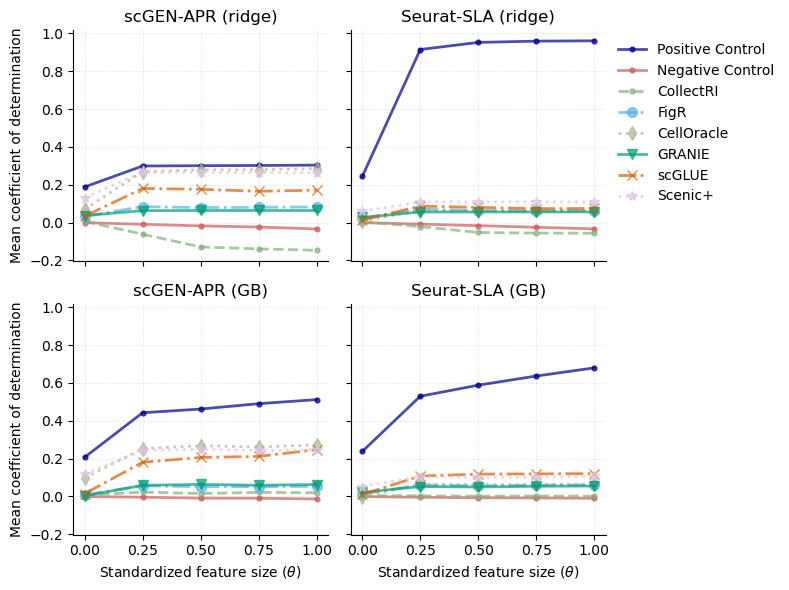

In [ ]:
subsample = 200

manipulate = None
exclude_missing_genes = False
tf_n = None

SORTED_METHODS = ['positive_control', 'negative_control', 'collectRI', 'figr', 'celloracle', 'granie', 'scglue', 'scenicplus']
NORM_METHODS = ['scgen_pearson',  'seurat_lognorm']

def line_plot_theta(reg_type, axes):
    
        
    markersize = 7
    linewidth = 2
    for k, norm_method,  in enumerate(NORM_METHODS):

        ax =axes[k]
        ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')
        xs = np.linspace(0, 1, 5)
        for method in SORTED_METHODS:

            series = []
            for theta in np.linspace(0, 1, 5):
                file =  f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{method}_{manipulate}.json'
                if not os.path.exists(file):
                    print(f'Missing file: {file}')
                    mean_score = np.nan
                else:
                    with open(file, 'r') as f:
                        data = json.load(f)
                    mean_score = data['mean_score_r2']

                series.append(float(mean_score))
            
            ax.plot(
                xs, series, label=surragate_names[method], color=COLORS[surragate_names[method]], markersize=markersize,
                linestyle=LINESTYLES[surragate_names[method]], marker=MARKERS[surragate_names[method]], alpha=0.7, linewidth=linewidth
            )

        ax.set_xticks(xs)
        ax.set_title(f'{surragate_names[norm_method]} ({reg_type})')
        if k == 0:
            ax.set_ylabel('Mean coefficient of determination')
        
            
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        if reg_type=='GB':
            ax.set_xlabel(r'Standardized feature size ($\theta$)')
        else:
            if k == 1:
                ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)


fig, axes = plt.subplots(2, len(NORM_METHODS), figsize=(4*len(NORM_METHODS), 6), sharey=True, sharex=True)

line_plot_theta('ridge', axes[0])
line_plot_theta('GB', axes[1])
plt.tight_layout()
plt.savefig(f'{work_dir}/benchmark/figs/first-validation-performance-theta.png', dpi=300, transparent=True)
plt.show()

## Subsample
run for all datasets for a subsample of 200 from 2100 samples


In [ ]:
experiment = 'default'
reg_type = 'ridge'
subsample=200 
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --force
# !python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --exclude-missing-genes --force

experiment='default',exclude_missing_genes=False,force=True, manipulate=None, subsample=200
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.033600852480656945 loss_mse:  0.19718029310314533
{'mean_score_r2': -0.033600852480656945, 'gene_scores_r2': [-0.8944613359755129, -0.2025664284460693, -0.026973275109317685, 0.025492714678525763, 0.069874425684198, -0.8515106559772345, -0.00359539957989341, -0.7228286134275275, -0.17092464474200808, -0.31586134539073196, -0.1460228918042319, 0.138849039724375, -0.010403657271844002, -0.3286210218675678, -3.435087980800448, -0.3052837159238089, -0.19054414190133007, -0.15621782837686715, -0.38266844389507293, 0.007703997652153904, -0.052784697673841974, -0.35621709340565233, -0.4344229783223885, -0.9648651637321728, -0.3471623289596293, -0.5417568341272128, -0.27406251392670833, -0.4000730358003173, -0.7257192472291993, -0.1586536938359311, -0.57208668909659

In [ ]:
experiment = 'default'
reg_type = 'GB'
subsample=200 
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} 
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --exclude-missing-genes

experiment='default',exclude_missing_genes=False,force=False, manipulate=None, subsample=200
reg_type='GB', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_1.0_tf_n_None/pearson/negative_control_None.json
reg_type='GB', norm_method='pearson', model_name='positive_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_1.0_tf_n_None/pearson/positive_control_None.json
reg_type='GB', norm_method='pearson', model_name='collectRI', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_1.0_tf_n_None/pearson/collectRI_None.json
reg_type='GB', norm_method='pearson', model_name='figr', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scor

### plot heatmap

Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/negative_control_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/collectRI_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/granie_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/celloracle_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/figr_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/scglue_None.json
Missing file: ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/rf/theta_1.0_tf_n_None/seurat_pearson/scenicplus_None.json
Missing file: .

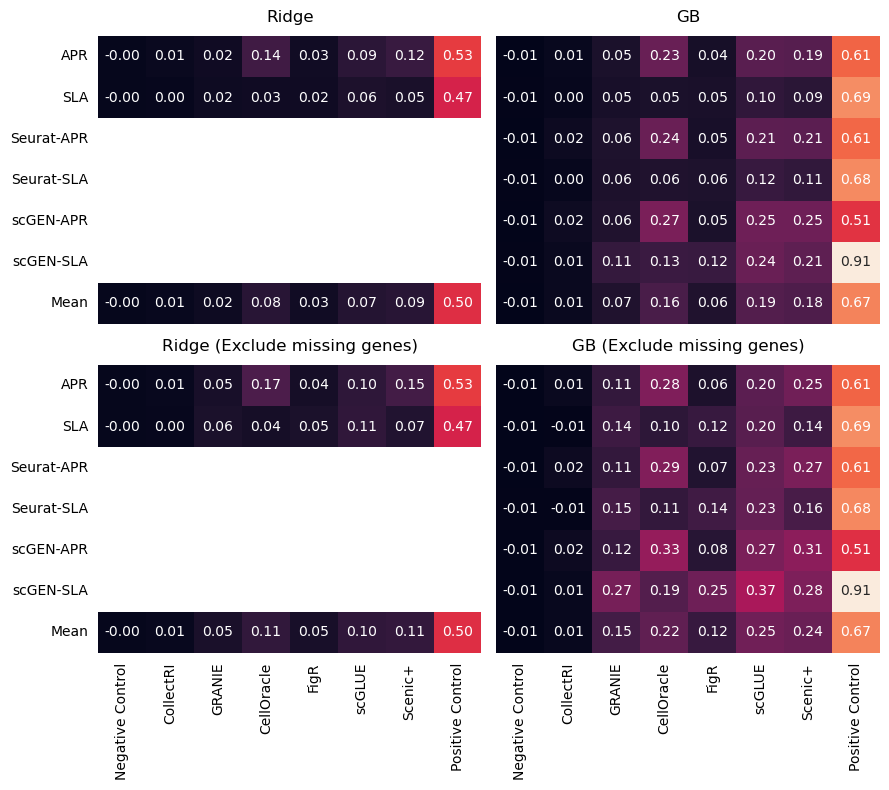

In [ ]:

manipulate=None
subsample=200
theta = 1.0
tf_n = None

fig, axes = plt.subplots(2, 2, figsize=(9, 8), sharey=True, sharex=True)
for j, exclude_missing_genes in enumerate([False, True]):
    mat_ridge = extract_table('rf', exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets=datasets, grn_models=grn_models)
    mat_gb = extract_table('GB', exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets=datasets, grn_models=grn_models)


    # Combine both correlation matrices to find global min and max
    combined_mat = np.concatenate((mat_ridge.values.flatten(), mat_gb.values.flatten()))
    vmin = np.nanmin(combined_mat)
    vmax = np.nanmax(combined_mat)

    for i, (name, mat_df) in enumerate(zip(['Ridge', 'GB'], [mat_ridge, mat_gb])):
        ax = axes[j][i]
        seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)
        # Remove only the ticks, keep labels
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_tick_params(width=0)
        ax.yaxis.set_tick_params(width=0)
        if exclude_missing_genes:
            ax.set_title(f'{name} (Exclude missing genes)', pad=10)
        else:
            ax.set_title(f'{name}', pad=10)

    plt.tight_layout()

# plt.savefig(f'{work_dir}/benchmark/figs/first-validation-heatmap-subset.png', dpi=300, transparent=True,  bbox_inches='tight')

### variation across datasets

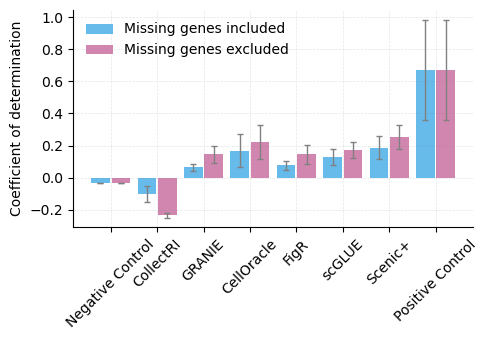

In [ ]:
datasets = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm'] # ['seurat_lognorm', 'scgen_pearson']
reg_type = 'ridge'

mat_GB =  extract_table(reg_type, exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=200, datasets=datasets, grn_models=grn_models)
mat_GB_exc =  extract_table(reg_type, exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=200, datasets=datasets, grn_models=grn_models)

means_GB = mat_GB.loc['Mean']
stds_GB = mat_GB.drop('Mean').std(axis=0)

means_GB_exc = mat_GB_exc.loc['Mean']
stds_GB_exc = mat_GB_exc.drop('Mean').std(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(5, 3.5))

# Number of columns
n_cols = len(means_GB.index)

# X-axis positions
x = np.arange(n_cols)

# Width of the bars
width = 0.4
alpha = 0.9
colors = ['#56B4E9',  # Sky Blue
          '#CC79A7'] 
error_kw = dict(elinewidth=1, capsize=2, capthick=1, ecolor='grey')


bars1 = ax.bar(x - width/2-.02, means_GB, width, yerr=stds_GB,  label='Missing genes included', color=colors[0], alpha=alpha, error_kw=error_kw)
bars2 = ax.bar(x + width/2+.02, means_GB_exc, width, yerr=stds_GB_exc, label='Missing genes excluded', color=colors[1], alpha=alpha, error_kw=error_kw)

ax.set_ylabel('Coefficient of determination')
ax.set_xticks(x)
ax.set_xticklabels(means_GB.index, rotation=45)
ax.legend(frameon=False)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')

plt.tight_layout()

plt.savefig(f'{work_dir}/benchmark/figs/first-validation-variations-{reg_type}.png', dpi=300, transparent=True,  bbox_inches='tight')
# plt.show()


### Correlation between regression types

In [ ]:
# lets find c
import scipy
scipy.stats.pearsonr(mat_gb.values.flatten(), mat_ridge.values.flatten())

PearsonRResult(statistic=0.9409050916630038, pvalue=4.646815272320079e-27)

### correlation between datasets 

In [ ]:
mat_ridge =  extract_table('ridge', exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample)
mat_ridge_exc =  extract_table('ridge', exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample)
mat_GB =  extract_table('GB', exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample)
mat_GB_exc =  extract_table('GB', exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample)

mat_ridge = pd.concat([mat_ridge,mat_ridge_exc], axis=1).drop('Mean')
mat_gb = pd.concat([mat_GB, mat_GB_exc], axis=1).drop('Mean')

In [ ]:
mat_GB.index

Index(['APR', 'SLA', 'Seurat-APR', 'Seurat-SLA', 'scGEN-APR', 'scGEN-SLA'], dtype='object')

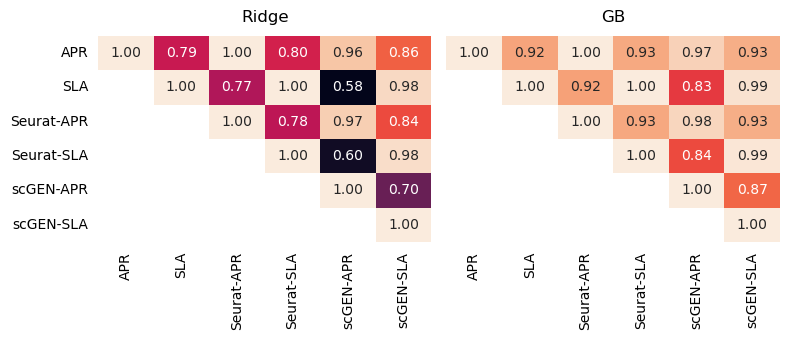

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
# Calculate the minimum and maximum correlation values across both datasets
df_corr_ridge = mat_ridge.T.corr().round(3)
df_corr_gb = mat_gb.T.corr().round(3)

# Combine both correlation matrices to find global min and max
combined_corr = np.concatenate((df_corr_ridge.values.flatten(), df_corr_gb.values.flatten()))
vmin = np.nanmin(combined_corr)
vmax = np.nanmax(combined_corr)

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True, sharex=True)
for i, (name, mat_df) in enumerate(zip(['Ridge', 'GB'], [mat_ridge, mat_gb])):  
    ax = axes[i]
    df_corr = mat_df.T.corr().round(3)
    mask = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)

    # Apply the mask to set values below the diagonal to NaN
    df_corr.where(~mask, other=np.nan, inplace=True)
    ax.set_title(name, pad=10)

    sns.heatmap(df_corr, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)

    # Remove only the ticks, keep labels
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)

plt.tight_layout()
plt.savefig(f'{work_dir}/benchmark/figs/datasets-correlation.png', dpi=300, transparent=True,  bbox_inches='tight')

## Full sample

In [ ]:
experiment = 'default'
reg_type = 'ridge'
!python regression.py --experiment {experiment} --reg_type {reg_type} --force
!python regression.py --experiment {experiment} --reg_type {reg_type} --exclude-missing-genes

reg_type = 'GB'
!python regression.py --experiment {experiment} --reg_type {reg_type} 
!python regression.py --experiment {experiment} --reg_type {reg_type} --exclude-missing-genes

experiment='default',exclude_missing_genes=False,force=True, manipulate=None, subsample=None
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 2170)
score_r2:  -0.033751769118423564 loss_mse:  0.17718242
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='positive_control', exclude_missing_genes=False
(15215, 1056) (15215, 2170)
score_r2:  0.3008037449724995 loss_mse:  0.11984045
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/positive_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='collectRI', exclude_missing_genes=False
(15215, 1178) (15215, 2170)
score_r2:  -0.15487881247502722 loss_mse:  0.19794318
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/th

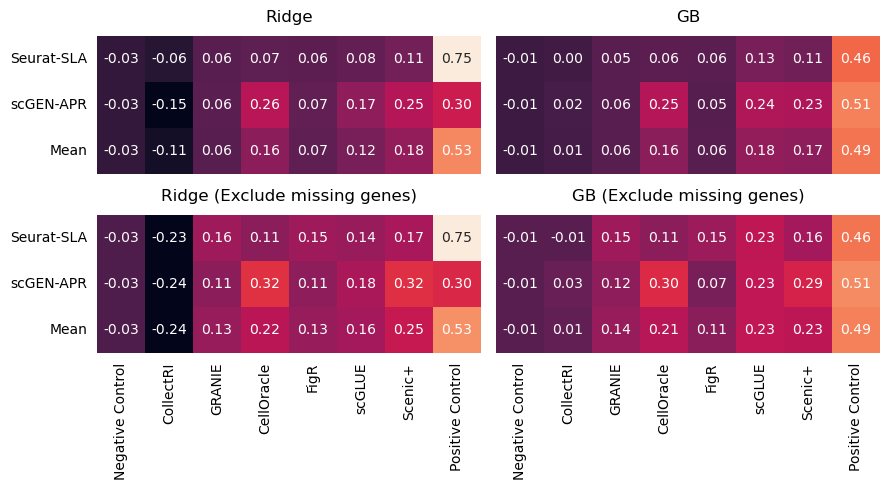

In [ ]:
manipulate=None
subsample=None
theta = 1.0
tf_n = None


datasets = ['seurat_lognorm', 'scgen_pearson']
fig, axes = plt.subplots(2, 2, figsize=(9, 5), sharey=True, sharex=True)
for j, exclude_missing_genes in enumerate([False, True]):
    mat_ridge = extract_table('ridge', exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets, grn_models)
    mat_gb = extract_table('GB', exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets, grn_models)


    # Combine both correlation matrices to find global min and max
    combined_mat = np.concatenate((mat_ridge.values.flatten(), mat_gb.values.flatten()))
    vmin = np.nanmin(combined_mat)
    vmax = np.nanmax(combined_mat)

    for i, (name, mat_df) in enumerate(zip(['Ridge', 'GB'], [mat_ridge, mat_gb])):
        ax = axes[j][i]
        seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)
        # Remove only the ticks, keep labels
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_tick_params(width=0)
        ax.yaxis.set_tick_params(width=0)
        if exclude_missing_genes:
            ax.set_title(f'{name} (Exclude missing genes)', pad=10)
        else:
            ax.set_title(f'{name}', pad=10)

    plt.tight_layout()

plt.savefig(f'{work_dir}/benchmark/figs/first-validation-heatmap.png', dpi=300, transparent=True,  bbox_inches='tight')

### Correlation between subsample and full

In [ ]:
import scipy.stats

for i, reg_type in enumerate(['ridge','GB']):
    mat =  extract_table(reg_type, exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=None).drop('Mean')
    mat_exc =  extract_table(reg_type, exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=None).drop('Mean')

    mat_sub =  extract_table(reg_type, exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=200).drop('Mean').loc[mat.index]
    mat_exc_sub =  extract_table(reg_type, exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=200).drop('Mean').loc[mat.index]

    mat = pd.concat([mat, mat_exc], axis=1)
    mat_sub = pd.concat([mat_sub, mat_exc_sub], axis=1)

    print(reg_type, scipy.stats.pearsonr(mat.values.flatten(), mat_sub.values.flatten()))

ridge PearsonRResult(statistic=0.9918495812983382, pvalue=2.087557029597194e-28)
GB PearsonRResult(statistic=0.9729588355840384, pvalue=1.19689469941413e-20)


### average across different tf-n

In [ ]:
mat_df0 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=140, subsample=None, datasets=datasets, grn_models=grn_models)
mat_df1 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=None, subsample=None, datasets=datasets, grn_models=grn_models)

mat_df1-mat_df0

Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/seurat_lognorm/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/scgen_pearson/scenicplus_None.json


Negative Control  CollectRI    GRANIE  CellOracle      FigR  \
Seurat-SLA         -0.004266  -0.002399  0.001348   -0.003633 -0.001329   
scGEN-APR          -0.006528   0.000459  0.003482    0.014362  0.003623   
Mean               -0.005397  -0.000970  0.002415    0.005365  0.001147   

              scGLUE  Scenic+  Positive Control  
Seurat-SLA  0.009938      NaN          0.038940  
scGEN-APR   0.033134      NaN          0.085304  
Mean        0.021536      NaN          0.062122

## Summarize scores 

In [ ]:
mat_g1_df0 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=140, subsample=None, datasets=datasets, grn_models=grn_models)
mat_g1_df1 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=None, subsample=None, datasets=datasets, grn_models=grn_models)

mat_g1_df0['Scenic+'] = mat_g1_df1['Scenic+']

mat_g0_df0 = extract_table(reg_type='GB', exclude_missing_genes=True, manipulate=None, theta=1.0, tf_n=140, subsample=None, datasets=datasets, grn_models=grn_models)
mat_g0_df1 = extract_table(reg_type='GB', exclude_missing_genes=True, manipulate=None, theta=1.0, tf_n=None, subsample=None, datasets=datasets, grn_models=grn_models)

mat_g0_df0['Scenic+'] = mat_g0_df1['Scenic+']

Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/seurat_lognorm/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/scgen_pearson/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_140/seurat_lognorm/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_140/scgen_pearson/scenicplus_None.json


In [ ]:
accuracy = (mat_g0_df0 + mat_g0_df1)/2
completeness = (mat_g1_df0 + mat_g1_df1)/2

summary = pd.DataFrame(columns=accuracy.columns)
summary.loc['Accuracy'] = accuracy.loc['Mean']
summary.loc['Comprehensiveness'] = completeness.loc['Mean']

summary

Negative Control  CollectRI    GRANIE  CellOracle  \
Accuracy                  -0.007917   0.010977  0.130268    0.206049   
Comprehensiveness         -0.007405   0.009336  0.054727    0.154620   

                       FigR    scGLUE   Scenic+  Positive Control  
Accuracy           0.105221  0.224002  0.226161          0.458723  
Comprehensiveness  0.054929  0.170397  0.169230          0.458723

In [ ]:
# regression 1 summary
metrics = ['g0_df0', 'g0_df1', 'g1_df0', 'g1_df1']
scores = [df.loc['Mean'].values for df in [mat_g0_df0, mat_g0_df1, mat_g1_df0, mat_g1_df1]]
models = mat_g0_df0.columns.values

reg1_summary = pd.DataFrame(scores, index=metrics, columns=models)
reg1_summary

Negative Control  CollectRI    GRANIE  CellOracle      FigR    scGLUE  \
g0_df0         -0.005213   0.011551  0.124610    0.204106  0.104239  0.217091   
g0_df1         -0.010620   0.010402  0.135925    0.207991  0.106202  0.230913   
g1_df0         -0.004707   0.009821  0.053520    0.151938  0.054355  0.159629   
g1_df1         -0.010104   0.008850  0.055935    0.157303  0.055502  0.181165   

         Scenic+  Positive Control  
g0_df0  0.226161          0.427649  
g0_df1  0.226161          0.489797  
g1_df0  0.169230          0.427661  
g1_df1  0.169230          0.489784

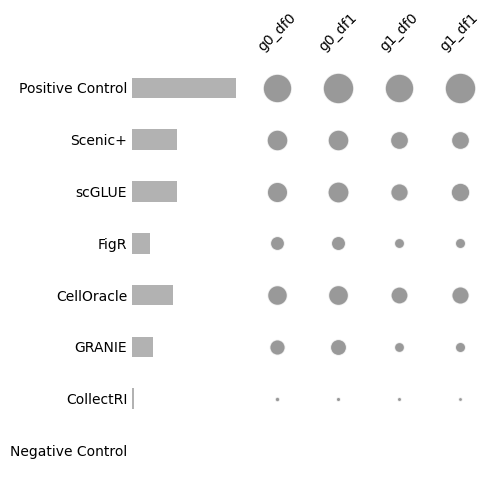

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
scale_size = 1000
alpha = .8
edgecolors='w'
fig, axes = plt.subplots(1, 2, figsize=(5, 5), gridspec_kw={'width_ratios': [1, 2]},sharey=True)

# Plot bars 
ax = axes[0]
bars = ax.barh(reg1_summary.columns, reg1_summary.mean(axis=0), color='grey', alpha=0.6, height=0.4)
ax.set_xticks([])
ax.tick_params(length=0)
for side in ['right', 'top', 'left', 'bottom']:
    ax.spines[side].set_visible(False)



# dots 
ax = axes[1]
reg1_summary = reg1_summary.where(reg1_summary>0, 0)
# print(reg1_summary)
xs = range(len(reg1_summary))
for i, (index, row) in enumerate(reg1_summary.iterrows()):
    for j in range(len(row.index)):
        ax.scatter(i, j, s=row.values[j]*scale_size,color='grey', alpha=alpha, edgecolors=edgecolors)
ax.set_xticks(range(len(reg1_summary)))
ax.set_xticklabels(reg1_summary.index, rotation=45, ha='center')
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, length=0)
for side in ['right', 'top', 'left', 'bottom']:
    ax.spines[side].set_visible(False)
ax.set_xmargin(.1)
# ax.set_xlabel('Score')
# ax.set_title('Scores by Method')


# ax.set_yticks(range(len(df)))
# ax.set_yticklabels(df['Name'])

# Hide y-tick labels on the right plot
# ax.tick_params(axis='y', which='both', length=0)

plt.tight_layout()
plt.show()


Negative Control  CollectRI    GRANIE  CellOracle  \
Accuracy                  -0.007917   0.010977  0.130268    0.206049   
Comprehensiveness         -0.007405   0.009336  0.054727    0.154620   

                       FigR    scGLUE   Scenic+  Positive Control  
Accuracy           0.105221  0.224002  0.226161          0.458723  
Comprehensiveness  0.054929  0.170397  0.169230          0.458723

## Signed 

In [ ]:
# EXPERIMENT: default 
experiment = 'default'
reg_type = 'ridge'
manipulate = 'signed'
subsample=200 
# !python regression.py --experiment {experiment} --reg_type {reg_type} --manipulate {manipulate} --subsample {subsample} --force
!python regression.py --experiment {experiment} --reg_type {reg_type} --manipulate {manipulate} --subsample {subsample} --force --exclude-missing-genes

experiment='default',exclude_missing_genes=True,force=True, manipulate='signed', subsample=200
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=True
(15215, 400) (15215, 200)
score_r2:  -0.033600852480656945 loss_mse:  0.19718029310314533
../output/benchmark/scores/subsample_200/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/pearson/negative_control_signed.json
reg_type='ridge', norm_method='pearson', model_name='positive_control', exclude_missing_genes=True
(15215, 1056) (15215, 200)
score_r2:  0.38458070793318966 loss_mse:  0.11740369224718186
../output/benchmark/scores/subsample_200/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/pearson/positive_control_signed.json
reg_type='ridge', norm_method='pearson', model_name='collectRI', exclude_missing_genes=True
(4193, 1178) (4193, 200)
score_r2:  -0.24839661913699293 loss_mse:  0.5066693790047916
../output/benchmark/scores/subsample_200/exclude_missing_genes_True/ridge/theta_1.0_tf_

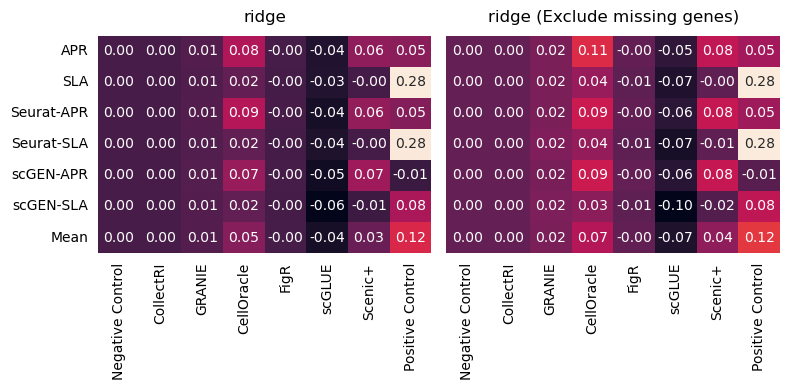

In [ ]:
# manipulate='signed'
subsample=200
theta = 1.0
tf_n = None

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
for j, exclude_missing_genes in enumerate([False, True]):
    name = 'ridge'
    mat_df_signed = extract_table(name, exclude_missing_genes, manipulate='signed', theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets ,grn_models=grn_models)
    mat_df = extract_table(name, exclude_missing_genes, manipulate=None, theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets ,grn_models=grn_models)

    mat_df = mat_df-mat_df_signed

    ax = axes[j]
    seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f')
    # Remove only the ticks, keep labels
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    if exclude_missing_genes:
        ax.set_title(f'{name} (Exclude missing genes)', pad=10)
    else:
        ax.set_title(f'{name}', pad=10)

    plt.tight_layout()

# plt.savefig(f'{work_dir}/benchmark/figs/first-validation-heatmap-subset.png', dpi=300, transparent=True,  bbox_inches='tight')

# End

In [ ]:
# experiment = 'default'
# reg_type = 'ridge'
# subsample = 200 
# !python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} -

from regression import main
main('positive_control', 'ridge', 'lognorm', 1.0, None, False, None, subsample=200, force=True)

reg_type='ridge', norm_method='lognorm', model_name='positive_control', exclude_missing_genes=False
2.3980817331903383e-16 0.5993078495656842
(15215, 1056) (15215, 200)
score_r2:  0.9898207580897078 loss_mse:  0.010114701747037729
{'mean_score_r2': 0.9898207580897078, 'gene_scores_r2': [0.8825149651098929, 0.9859720547630081, 0.9941082437248988, 0.9993549664772585, 0.9968299704868617, 0.9885959582714353, 0.9815621007221352, 0.9622073827233347, 0.9995410909408915, 0.9911457243579898, 0.9970560100167964, 0.9857996555526005, 0.9971580902511238, 0.9963960274386553, 0.9957546046089677, 0.990211481781965, 0.9960309535371307, 0.9653154995636711, 0.9887339169417825, 0.9852699125401458, 0.9964213704827837, 0.9994916800354288, 0.9972140485645015, 0.976382031216999, 0.9987616080871531, 0.9945490332785055, 0.9983596701039056, 0.9811106867603817, 0.9887939077276056, 0.9934179669769662, 0.9919458812006667, 0.9974520764972464, 0.9968669867010479, 0.9978368137395344, 0.9906975528322023, 0.975962237166

In [ ]:
import sys
sys.path.append('/lustre1/project/stg_00019/research/Antoine/dependencies')

import os
import argparse
import json
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm
import random 


def set_global_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    lightgbm.LGBMRegressor().set_params(random_state=seed)



# class lightgbm_wrapper:
#     def __init__(self, params):
#         self.params =  params
        
#     def fit(self, X_train, Y_train):
#         self.n_sample = Y_train.shape[1]
#         self.regr_samples = []
#         for i in range(self.n_sample):
#             regr = lightgbm.LGBMRegressor(**self.params)
#             regr.fit(X_train, Y_train[:, i])
#             self.regr_samples.append(regr)
            
            
#     def predict(self,X_test):
#         y_pred_list = []
#         for i in range(self.n_sample):
#             regr = self.regr_samples[i]
#             y_pred = regr.predict(X_test)
#             y_pred_list.append(y_pred)
#         return np.stack(y_pred_list, axis=1)
from concurrent.futures import ThreadPoolExecutor

class lightgbm_wrapper:
    def __init__(self, params, max_workers=None):
        self.params =  params
        self.max_workers = max_workers
        
    def fit(self, X_train, Y_train):
        self.n_sample = Y_train.shape[1]
        self.regr_samples = [None] * self.n_sample
        
        def fit_sample(i):
            regr = lightgbm.LGBMRegressor(**self.params)
            regr.fit(X_train, Y_train[:, i])
            self.regr_samples[i] = regr
        
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            executor.map(fit_sample, range(self.n_sample))
            
    def predict(self, X_test):
        def predict_sample(i):
            regr = self.regr_samples[i]
            return regr.predict(X_test)
        
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            y_pred_list = list(executor.map(predict_sample, range(self.n_sample)))
        
        return np.stack(y_pred_list, axis=1)


def cv_5(genes_n):
    '''5 fold standard'''
    num_groups = 5
    group_size = genes_n // num_groups
    groups = np.repeat(np.arange(num_groups), group_size)
    if genes_n % num_groups != 0:
        groups = np.concatenate((groups, np.arange(genes_n % num_groups)))
    np.random.shuffle(groups)
    return groups

def degree_centrality(net, source='source', target='target', normalize=False):
    counts = net.groupby(source)[target].nunique().values
    if normalize:
        total_targets = net[target].nunique()
        counts = counts / total_targets
    return counts


def create_positive_control(X: np.ndarray) -> np.ndarray:
    X = StandardScaler().fit_transform(X) #TODO: can go 
    return np.dot(X.T, X) / X.shape[0]

def pivot_grn(net):
    # Remove self-regulations
    net = net[net['source'] != net['target']]
    df_tmp = net.pivot(index='target', columns='source', values='weight')
    return df_tmp.fillna(0)
def run_method_1(
            net: pd.DataFrame, 
            train_df: pd.DataFrame,
            reg_type: str = 'GRB',
            exclude_missing_genes: bool = False,
            verbose: int = 0) -> None: 
    """
    net: a df with index as genes and columns as tfs
    train_df: a df with index as genes and columns as samples
    """
    gene_names = train_df.index.to_numpy()
    gene_names_grn = net.index.to_numpy()
    # determine regressor 
    if reg_type=='ridge':
        # regr = Pipeline([
        #     ('scaler', StandardScaler()),
        #     ('svc', Ridge(random_state=32))
        # ])
        regr =  Ridge(**dict(random_state=32))
    elif reg_type=='GB':
        regr = lightgbm_wrapper(dict(random_state=32, n_estimators=100, min_samples_leaf=2, min_child_samples=1, feature_fraction=0.05, verbosity=-1))
    elif reg_type=='RF':
        regr = lightgbm_wrapper(dict(boosting_type='rf',random_state=32, n_estimators=100,  feature_fraction=0.05, verbosity=-1))
    elif reg_type=='HGB':
        from sklearn.ensemble import HistGradientBoostingRegressor
        from sklearn.multioutput import MultiOutputRegressor
        regr = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=42), n_jobs=-1)
    else:
        raise ValueError("define first")        
    
    n_tfs = net.shape[1]
    # construct feature and target space
    if exclude_missing_genes:
        included_genes = gene_names_grn
    else:
        included_genes = gene_names
    
    X_df = pd.DataFrame(np.zeros((len(included_genes), n_tfs)), index=included_genes)
    Y_df = train_df.loc[included_genes,:]

    mask_shared_genes = X_df.index.isin(net.index)
    print(X_df.shape, Y_df.shape)
    
    # fill the actuall regulatory links
    X_df.loc[mask_shared_genes, :] = net.values
    X = X_df.values.copy()

    # run cv 
    groups = cv_5(len(included_genes))
    # initialize y_pred with the mean of gene expressed across all samples
    means = Y_df.mean(axis=0)
    y_pred = Y_df.copy()
    y_pred[:] = means
    y_pred = y_pred.values

    
    # initialize y_true
    Y = Y_df.values
    y_true = Y.copy()

    unique_groups = np.unique(groups)
    
    for group in unique_groups:
        mask_va = groups == group
        mask_tr = ~mask_va

        # Use logical AND to combine masks correctly
        X_tr = X[mask_tr & mask_shared_genes, :]
        Y_tr = Y[mask_tr & mask_shared_genes, :]

        regr.fit(X_tr, Y_tr)

        y_pred[mask_va & mask_shared_genes, :] = regr.predict(X[mask_va & mask_shared_genes, :])


    # assert ~(y_true==0).any()

    # if verbose >= 1:
    score_r2  = r2_score(y_true, y_pred, multioutput='variance_weighted') #uniform_average', 'variance_weighted
    loss_mse  = mean_squared_error(y_true, y_pred)
    print(f'score_r2: ', score_r2, 'loss_mse: ', loss_mse)


    mean_score_r2 = r2_score(y_true, y_pred, multioutput='variance_weighted')
    gene_scores_r2 = r2_score(y_true.T, y_pred.T, multioutput='raw_values')

    output = dict(mean_score_r2=mean_score_r2, gene_scores_r2=list(gene_scores_r2))

    return output


def main(model_name: str, reg_type: str, norm_method: str, theta: float, tf_n:int, exclude_missing_genes: bool, manipulate: bool, subsample=None, force=False):
    

    train_data = adata_rna.layers[norm_method].copy()
    train_df = pd.DataFrame(train_data, columns=adata_rna.var_names)
    if subsample is not None:
        train_df = train_df.sample(n=subsample, random_state=42) #TODO: remove this
    # check if the file already exist
    print(f'{reg_type=}, {norm_method=}, {model_name=}, {exclude_missing_genes=}')
    folder = format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)
    os.makedirs(folder, exist_ok=True)
    file = f'{folder}/{model_name}_{manipulate}.json'

    if os.path.exists(file):
        if force==False:
            print('Skip running because file exists: ',file)
            return 
    
    # get the grn model
    if model_name in ['positive_control', 'negative_control']:
        net=None 
    else:
        net = pd.read_csv(f'../output/benchmark/grn_models/{model_name}.csv', index_col=0)
    
    # case dependent modifications
    if model_name == 'positive_control':
        net = create_positive_control(train_df)
        net = pd.DataFrame(net, index=gene_names, columns=gene_names)
        net = net.loc[:, net.columns.isin(tf_all)]
        
    elif model_name == 'negative_control':
        ratio = [.98, .01, 0.01]
        net = np.random.choice([0, -1, 1], size=((len(gene_names), 400)),p=ratio)
        net = pd.DataFrame(net, index=gene_names)

    else:
        net = pivot_grn(net)
        net = net[net.index.isin(gene_names)]
        
    # Subset TFs 
    if tf_n is None:
        if False:
            net_sign = net.values
            net_sign[net_sign>0]=1
            net_sign[net_sign<0]=-1
            net_sign = pd.DataFrame(net_sign, index=net.index, columns=net.columns)
            degrees = net_sign.abs().sum(axis=0)
        else:
            degrees = net.abs().sum(axis=0)
        net = net.loc[:, degrees>=degrees.quantile((1-theta))]
    else:

        if tf_n>net.shape[1]:

            print(f'Skip running because tf_n ({tf_n}) is bigger than net.shape[1] ({net.shape[1]})')
            return 
        degrees = net.abs().sum(axis=0)
        net = net[degrees.nlargest(tf_n).index]

    train_df = train_df.T # make it gene*sample

    # manipulate
    if manipulate=='signed':
        net = net.map(lambda x: 1 if x>0 else (-1 if x<0 else 0))


    output = run_method_1(net, train_df, exclude_missing_genes=exclude_missing_genes, reg_type=reg_type)
    
    print(output)
    print(file)
    with open(file, 'w') as f:
        json.dump(output, f)

def format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample=None):
    return f'{work_dir}/benchmark/scores/subsample_{subsample}/exclude_missing_genes_{exclude_missing_genes}/{reg_type}/theta_{theta}_tf_n_{tf_n}/{norm_method}'



In [ ]:
work_dir = '../output'
DATA_DIR = os.path.join('..', 'output', 'preprocess')
adata_rna = ad.read_h5ad(os.path.join(DATA_DIR, 'bulk_adata_integrated.h5ad'))
gene_names = adata_rna.var.index.to_numpy()
tf_all = np.loadtxt(f'{work_dir}/utoronto_human_tfs_v_1.01.txt', dtype=str)


In [ ]:
set_global_seed(32)

exclude_missing_genes = False
experiment = 'default'
force = True
manipulate= None
reg_type='ridge'
subsample=200

norm_method = 'pearson'

theta = 1.0
tf_n = None

grn_model_names = ['scglue', 'collectRI', 'figr', 'celloracle', 'granie',  'scenicplus']

for grn_model in grn_model_names:
    main(grn_model, reg_type, norm_method, theta, tf_n, exclude_missing_genes, manipulate, subsample, force)

reg_type='ridge', norm_method='pearson', model_name='scglue', exclude_missing_genes=False
(15215, 439) (15215, 200)
score_r2:  -8.638540015497696 loss_mse:  1.8387466890927302
{'mean_score_r2': -8.638540015497696, 'gene_scores_r2': [-0.23515952188601696, -0.08108832777465036, -0.42078433496641265, 0.11471500968666104, -0.013143319978327073, -0.003948151990897486, -0.01915975079781118, 0.11576577745675587, 0.5127239039995812, 0.05101175526315305, 0.05171106933083047, 0.13296502250362985, 0.055098642832647426, 0.12045355885410725, -0.1387887585596348, -0.1573722679360714, -0.03338436224923913, -0.07913022416144799, -0.5922915952326309, -0.28393438942107707, -0.06561401812415513, 0.4073977253167921, -1.1090660731683997, -0.17429925044845218, 0.07664552182298323, 0.11870577901180746, 0.09809852028078847, -0.01683188198317609, -0.0719261336565502, 0.42613367129141755, 0.08958367488198227, -1.1450991711293348, 0.5982415120793467, -0.07751372006868129, 0.0677716289857202, -1.058895511161586, 

In [ ]:
subsample = 200

train_data = adata_rna.layers[norm_method].copy()
train_df = pd.DataFrame(train_data, columns=adata_rna.var_names)
if subsample is not None:
    train_df = train_df.sample(n=subsample, random_state=42) #TODO: remove this

train_df = train_df.T # make it gene*sample


In [ ]:
for grn_model in ['granie','scglue','scenicplus']:
    print(grn_model)
    net = pd.read_csv(f'{work_dir}/benchmark/grn_models/{grn_model}.csv')
    net = pivot_grn(net)
    net = net[net.index.isin(gene_names)]
    # net.iloc[:,:] = StandardScaler().fit_transform(net.values)
        
    run_method_1(net, train_df, exclude_missing_genes=exclude_missing_genes, reg_type='HGB')['mean_score_r2']
# np.mean(

granie
(15215, 180) (15215, 200)
score_r2:  0.06353747976748537 loss_mse:  0.17864918916851713
scglue
(15215, 439) (15215, 200)


KeyboardInterrupt: 

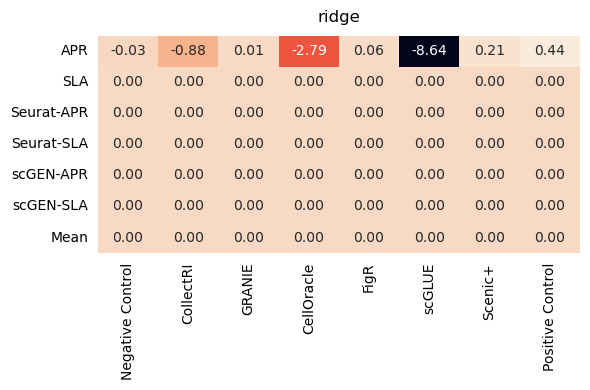

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True)

name = 'ridge'
mat_df = extract_table(name, exclude_missing_genes, manipulate=None, theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets ,grn_models=grn_models)
mask = mat_df.index == 'APR'
mat_df.loc[~mask,:] = 0
seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f')
# Remove only the ticks, keep labels
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)
if exclude_missing_genes:
    ax.set_title(f'{name} (Exclude missing genes)', pad=10)
else:
    ax.set_title(f'{name}', pad=10)

plt.tight_layout()

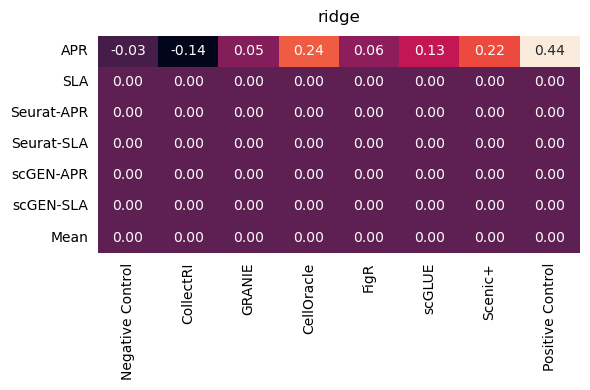